In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses

from json import load

In [11]:
with open("../data/example_build.json","r") as build_file:
    build_config = load(build_file)

In [12]:
inputs = []
train_config = {
    "dataset":None,
    "optimizer":None,
    "model":None,
    "compile":None,
    "train":None
}


for _id,config in build_config.items():
    if config['type'] == 'Input':
        inputs.append(_id)
        
    elif config['type'] == 'Dataset':
        train_config['dataset'] = _id
        
    elif config['type'] == 'Optimizer':
        train_config['optimizer'] = _id
    
build_config['input_nodes'] = inputs
levels = [ set() for i in range(len(build_config))]
def setLevel(node,config,di=0):
    levels[di].add(node)
    if build_config[node]['connections']['outbound']:
        for next_node in build_config[node]['connections']['outbound']: 
            setLevel(next_node,build_config,di+1)


for inp in inputs:
    setLevel(inp,build_config,0)
    
build_config['levels'] = levels
    
levels = [list(level) for level in levels if len(level)]

In [13]:
if train_config['optimizer']:
    opt = build_config[train_config['optimizer']]
    opt['_type'] = 'Adam'
    
    arguments =  build_arguments(opt['arguments'])  
    globals()[opt['id']] = eval(f"""optimizers.{opt['_type']}(
        {arguments}
    )""")
    
if train_config['dataset']:
    data = build_config[train_config['dataset']]
    exec(data['arguments']['dataset']['value']+f"""
globals()['{train_config['dataset']}'] = Dataset()
""")

In [14]:
def build_inbound(inbound:list)->str:
    inbound = [ f"""build_config['train']['{node}']""" for node in inbound ]
    return ( "([" + ", ".join(inbound) + "])" if len(inbound) > 1 else "(" + inbound[0] + ")" ) if len(inbound) else ""

def set_argument(argument,config):
    value = config['value']
    try:
        value = eval(value)
    except:
        pass
    return f"    {argument}={value.__repr__() if config['type']=='str' else value},"
    
def build_arguments(arguments:dict)->str:
    arguments = '\n'.join([ set_argument(arg,cnf) for arg,cnf in arguments.items() ])
    return arguments

def build_input(layer,build_config,*args,**kwargs)->str:
    arguments =  build_arguments(layer['arguments'])
    return eval(f"""layers.Input(
{arguments}
)
""")

def build_default(layer,build_config,*args,**kwargs)->str:
    arguments =  build_arguments(layer['arguments'])
    inbound = build_inbound(layer['connections']['inbound'])
    
    return eval(f"""layers.{layer['type']}(
{arguments}
){inbound}
""")

def build_optimizer(layer,build_config):
    arguments =  build_arguments(layer['arguments'])  
    globals()[layer['id']] = eval(f"""optimizers.{opt['_type']}(
        {arguments}
    )""")
    return globals()[layer['id']]


def build_model(layer,build_config,*args,**kwargs)->str:
    in_nodes = [ f"""build_config['train']['{node}']""" for node in build_config['input_nodes']]
    out_nodes = [ f"""build_config['train']['{node}']""" for node in layer['connections']['inbound']]
    return eval(f"""keras.Model(
    [ {', '.join(in_nodes)}, ],
    [ {', '.join(out_nodes)}, ]
)""")

def build_compile(layer,build_config,*args,**kwargs)->str:
    model,*_ = [node for node in layer['connections']['inbound'] if "model" in node]
    eval(f"""
build_config['train']['{model}'].compile(
    optimizer={train_config['optimizer'] if train_config['optimizer'] else "'"+layer['arguments']['optmizer']['value']+"'"},
    loss='{layer['arguments']['loss']['value']}',
)""")
    return True

def build_train(layer,build_config,*args,**kwargs)->str:
    train_config['train'] = layer
    return ""

In [15]:
build_functions = {
    "Input":build_input,
    "default":build_default,
    "Model":build_model,
    "Compile":build_compile,
    "Train":build_train
}

build_config['train'] = {
    
}

for level in levels:
    for layer in level:
        layer = build_config[layer]
        if layer['type'] in build_functions:
            layer_build = build_functions[layer['type']](layer,build_config) 
        else:
            layer_build = build_functions['default'](layer,build_config) 
        build_config['train'][layer['id']] = layer_build
        
build_config['train']

{'input_1': <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'input_1')>,
 'dense_1': <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense')>,
 'dense_2': <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>,
 'model_1': <tensorflow.python.keras.engine.functional.Functional at 0x20ed65b3d00>,
 'compile_1': True,
 'train_1': ''}

In [16]:
if train_config['dataset']:
    data = build_config[train_config['dataset']]
    exec(data['arguments']['dataset']['value']+f"""
globals()['{train_config['dataset']}'] = Dataset()
""")

In [17]:
model = build_config['train']['model_1']

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class TfGui(keras.callbacks.Callback):
    batch = None
    logs = []
    def on_batch_end(self,batch,logs=None):
        self.batch = batch
        self.logs.append(logs)
    
    def on_epoch_end(self,epoch,logs=None):
        print (self.model)
    
tf_gui = TfGui()

In [ ]:
dataset = globals()[train_config['dataset']]

model.fit(
    x=dataset.train_x,
    y=dataset.train_y,
    epochs=1,
    batch_size=32,
    validation_data=(dataset.test_x,dataset.test_y) if dataset.validate else None,
    callbacks=[tf_gui]
)

In [ ]:
tf_gui.logs

In [ ]:
from json import dumps

In [ ]:
dumps([
    {'type': 'notif', 'data': {'message': 'Copiling Code'}}, {'type': 'notif', 'data': {'message': 'Performing imports'}}, {'type': 'notif', 'data': {'message': 'Building Model'}}, {'type': 'notif', 'data': {'message': 'Compiling Model'}}, {'type': 'notif', 'data': {'message': 'Training Started'}}, {'type': 'epoch', 'data': {'epoch': 0, 'log': {'batch': 745, 'output': {'loss': 1.227247953414917}}, 'train': {'epochs': 1, 'batches': 7500}}}
])

In [8]:
import cv2
import base64

import numpy as np
import matplotlib.pyplot as plt

In [26]:
images = np.random.randint(0,255,(128,128,3)).astype(np.uint8)

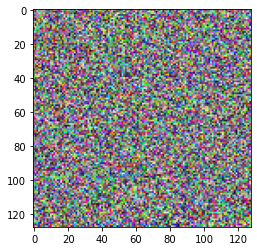

In [27]:
plt.imshow(images)

''
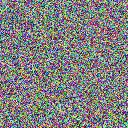